# [オンライン開催]セキュリティから学ぶ機械学習第4回
SQLインジェクションのデータセットを題材に、機械学習を学ぶ回になります。

## Section0. 概要

---

SQLインジェクションはアプリケーションの脆弱性を攻撃し、個人情報漏えい事故につながる可能性があるサイバー攻撃の1つです。

有名なサイバー攻撃として、「[DDoS攻撃](https://www.shadan-kun.com/waf/dos_ddos_attack/)」や「ブルートフォースアタック」がありますが、その中でも、特に悪質な攻撃がこの「SQLインジェクション」です。サイバーセキュリティクラウドが発表した「[2021年上半期サイバー攻撃検知レポート](https://www.cscloud.co.jp/news/press/202108043458/?_ga=2.200989869.261509358.1683938887-1850398770.1682414659)」では、前年同時期に比べてSQLインジェクションの検知が約500万件増えており、ますます注意が必要な攻撃です。

[SQLインジェクションとは？仕組み・被害事例・対策をわかりやすく解説](https://www.shadan-kun.com/waf_websecurity/sql_injection/)より引用



---


私たちが日常的に利用しているショッピングサイトやその他オンラインコマースサービスでのサイトなどは、データベースと連携したWEBアプリケーションであることがほとんどです。

その多くのサービスが利用者の入力をもとにSQL文を組み立て、商品検索などのを可能としています。この時、WEBアプリケーション側でのSQL文の組み立て方法に問題がある場合、それを悪用してデータベースの不正利用を招くおそれがあります。
[差し迫る敵：金融サービスに対する攻撃の分析 AKAMAI ](https://colab.research.google.com/drive/13WPZqgBfq01JnGQ0hXYBTYO7evMysJSn#scrollTo=OeDGleyhprPA&line=18&uniqifier=1) にもレポートされているように、WEBアプリケーションを狙う攻撃のうち、SQLインジェクションによる被害も挙げられています。

今回は、このSQLインジェクションを検出するための機械学習モデルを作成したいと思います。



*   特徴量エンジニアリング
*   N-gramによる特徴量の抽出
*   SQLインジェクション検出器の作成




## Section1. データセットと特徴量の作成
**・データセット**  
[HttpParamsDataset](https://github.com/Morzeux/HttpParamsDataset)を利用します。このデータセットは、Morzeux氏が卒業論文で異常検出方法を評価するために使用された、HTTP リクエストのパラメーターの値の集合となります。パラメータには 3100 を超える値が含まれており、これらの値は 2 つのカテゴリに分類されています。



*   19304件の正常データとラベリングされたHTTPクエリ文字列
*   11763件の異常とラベリングされたHTTPクエリ文字列

クエリ文字列には、攻撃タイプとしてSQLインジェクション、[クロスサイトスクリプティング](https://www.shadan-kun.com/waf_websecurity/xss/)、[コマンドインジェクション](https://www.shadan-kun.com/blog/measure/2873/)、[ディレクトリトラバーサル](https://www.lrm.jp/security_magazine/directory_traversal/)を示すラベルが付与されています。
  

**・特徴量**  
エントロピーやSQLインジェクションに固有な表現（特徴的な文字）をもとに、特徴量を作成していきます。


### Section1-1. データセットの用意と環境の準備

In [1]:
!git clone https://github.com/Morzeux/HttpParamsDataset

Cloning into 'HttpParamsDataset'...
remote: Enumerating objects: 17, done.
remote: Total 17 (delta 0), reused 0 (delta 0), pack-reused 17
Unpacking objects: 100% (17/17), 697.62 KiB | 1.88 MiB/s, done.


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')

In [3]:
df

,payload,length,attack_type,label
0,c/ caridad s/n,14,norm,norm
1,"campello, el",12,norm,norm
2,1442431887503330,16,norm,norm
3,nue37,5,norm,norm
4,tufts3@joll.rs,14,norm,norm
...,...,...,...,...
20707,"<!--#exec cmd=""/bin/echo '<script src'""--><!--...",110,xss,anom
20708,"<head><meta http-equiv=""content-type"" content=...",127,xss,anom
20709,"<script a="">"" id=xss src=""http://ha.ckers.org/...",63,xss,anom
20710,"<script ""a='>'"" id=xss src=""http://ha.ckers.or...",65,xss,anom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20712 entries, 0 to 20711
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   payload      20712 non-null  object
 1   length       20712 non-null  int64 
 2   attack_type  20712 non-null  object
 3   label        20712 non-null  object
dtypes: int64(1), object(3)
memory usage: 647.4+ KB


In [5]:
df.describe()

,length
count,20712.000000
mean,41.106701
std,56.334657
min,1.000000
25%,8.000000
50%,16.000000
75%,54.000000
max,1058.000000


このままの状態では、数値として識別できるのは `length`という列のみです。これは、`payload`列のHTTPクエリ文字列の長さとなります。このままのデータを利用すると、特徴量は、ひとつのみの特徴量となってしまいます。ここからさらに、特徴量を追加できないか検討してみます。

### Section1-2. 特徴量の追加(エントロピー)
情報学、情報科学においては、平均情報量（エントロピー）という概念があります。このエントロピーとは、情報源がどれほどの情報があるか（乱雑さ、不規則さ）について測るための尺度となります。つまり、エントロピーとは『曖昧さ』を表現するための値、といえます。ある情報が不規則であればあるほど、平均して多くの情報を含んでいると捉えます。  
  
エントロピーの尺度の１つに、[Shannon](http://st-phys.blogspot.com/2019/06/shannon-entropy.html)があります。  
  
$$
H (X) = - \sum_{n=1}^{n}P_{i}{\log_{2}} P_{i}
$$

ここで１つの仮説として、正常なHTTPクエリ文字列と比較して、SQLインジェクションを含むHTTPクエリ文字列は攻撃としての固定された表現がある規則性のある文字列を含むと考えます。SQLインジェクションには一定の規則に基づいたSQL構文があるため、エントロピー(不規則性)は小さくなるはずです。  
  
この考え方から、エントロピーを使用して `payload`列のHTTPクエリ文字列を数値的な表現に変換して、特徴量を追加してみます。

In [ ]:
import numpy as np
import pandas as pd

# HTTPクエリストリングのエントロピーの計算
def H_entropy(x):
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

考え方が正しければ、通常のHTTPクエリ文字列のエントロピーの分布と、SQLインジェクションを含むHTTPクエリ文字列のエントロピーの分布は異なるはずです。

In [ ]:
# 通常であるとラベリングされた行列のみを抽出
df_norm = df[df.attack_type == 'norm']

# 算出されたエントロピーを格納するリストを用意
norm_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_norm['payload']:
    
    # エントロピーの計算と代入
    norm_entropies.append(H_entropy(i))

In [ ]:
sum(norm_entropies) / len(norm_entropies)

2.7658075808985836

通常のHTTPクエリ文字列のエントロピー平均値

In [ ]:
# SQLインジェクションであるとラベリングされた行列のみを抽出
df_sqli = df[df.attack_type == 'sqli']

# 算出されたエントロピーを格納するリストを用意
sqli_entropies = []

# payload列からHTTPクエリストリングを取り出して処理させる
for i in df_sqli['payload']:
    
    # エントロピーの計算と代入
    sqli_entropies.append(H_entropy(i))

In [ ]:
sum(sqli_entropies) / len(sqli_entropies)

4.289379819336267

SQLインジェクションを含むHTTPクエリ文字列のエントロピー平均値

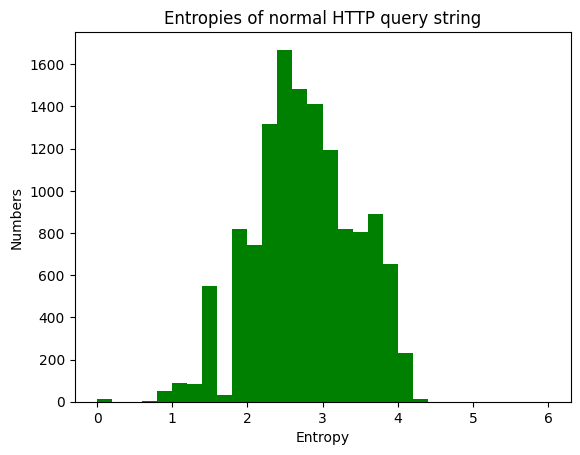

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of normal HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(norm_entropies, bins=30, range=(0,6), color='green')
plt.show()

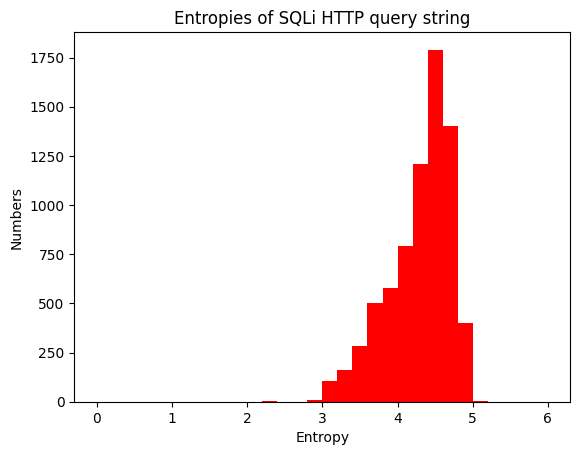

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# グラフのタイトルとラベルの設定
ax.set_title('Entropies of SQLi HTTP query string')
ax.set_xlabel('Entropy')
ax.set_ylabel('Numbers')

# 度数分布グラフの描画
plt.hist(sqli_entropies, bins=30, range=(0,6), color='red')
plt.show()

通常のHTTPクエリ文字列と、SQLインジェクションを含むHTTPクエリ文字列の、それぞれのエントロピー分布には違いがはっきりとみて取れるため、エントロピーを用いて分類や検出ができる可能性がある。

### Section1-3. SQLインジェクション固有の表現
ここからは、文字列そのものに注目してみます。

In [6]:
df_sqli = df[df.attack_type == 'sqli']
df_sqli

,payload,length,attack_type,label
291,1' where 6406=6406;select count(*) from rdb$fi...,115,sqli,anom
292,1) and 8514=(select count(*) from domain.domai...,111,sqli,anom
293,1) where 7956=7956 or sleep(5)#,31,sqli,anom
294,-7387'))) order by 1--,22,sqli,anom
295,"1))) union all select null,null,null#",37,sqli,anom
...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,anom
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,anom
20362,"1"" order by 1--",15,sqli,anom
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,anom


In [7]:
df_norm = df[df.attack_type == 'norm']
df_norm

,payload,length,attack_type,label
0,c/ caridad s/n,14,norm,norm
1,"campello, el",12,norm,norm
2,1442431887503330,16,norm,norm
3,nue37,5,norm,norm
4,tufts3@joll.rs,14,norm,norm
...,...,...,...,...
17907,envelar,7,norm,norm
17908,medioni5,8,norm,norm
17909,esdrs,5,norm,norm
17910,celeste_bryon@skullride.ki,26,norm,norm


SQLインジェクションを含むHTTPクエリ文字列は、)を多く含んでいるように見えます。

In [ ]:
print('{:.2%}'.format(
    df_sqli['payload'].str.contains('\)').sum() \
    / len(df_sqli['payload'])
    )
)

90.91%


In [ ]:
df_norm = df[df.attack_type == 'norm']
print('{:.2%}'.format(
    df_norm['payload'].str.contains('\)').sum() \
    / len(df_norm['payload'])
    )
)

0.01%


やはり、SQLインジェクションを含むHTTPクエリ文字列のほぼ全てにおいて、）を含む一方で、通常のHTTPクエリ文字列は、）をほとんど含まないことがわかりました。)は、SQLインジェクションを含むHTTPクエリ文字列の固有表現といえます。

In [ ]:
def func_preprocessing(df):
    train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
    df = df[train_rows]

    # エントロピーと閉じ括弧の有無を入れる配列
    entropies = []
    closing_parenthesis = []
    
    # payload列からHTTPクエリストリングを取り出して処理させる
    for i in df['payload']:
        # エントロピーの計算と代入
        entropies.append(H_entropy(i))
        
        # 閉じ括弧を検出して、存在した場合は列closing_parenthesisに1を設定、
        # ない場合は0を設定
        if i.count(')'):
            closing_parenthesis.append(1)
        else:
            closing_parenthesis.append(0)
    
    # データセットに新たに列を追加
    df = df.assign(entropy=entropies)
    df = df.assign(closing_parenthesis=closing_parenthesis)
    
    # データセットのlabel列のnormを0に、anormを1に変更
    rep = df.label.replace({"norm":0,"anom":1})
    df = df.assign(label=rep)
    
    return df

In [ ]:
df = func_preprocessing(df)

In [ ]:
df

,payload,length,attack_type,label,entropy,closing_parenthesis
0,c/ caridad s/n,14,norm,0,3.093069,0
1,"campello, el",12,norm,0,3.022055,0
2,1442431887503330,16,norm,0,2.827820,0
3,nue37,5,norm,0,2.321928,0
4,tufts3@joll.rs,14,norm,0,3.378783,0
...,...,...,...,...,...,...
20360,"1%"")) and elt(4249=4249,7259) and ((""%""=""",41,sqli,1,4.064392,1
20361,-7773' or 5903=('qqpjq'||(select case 5903 whe...,99,sqli,1,4.718866,1
20362,"1"" order by 1--",15,sqli,1,3.189898,0
20363,"1' procedure analyse(extractvalue(5840,concat(...",149,sqli,1,4.641613,1


## Section2. 検出器の作成
今回のデータセットは、あらかじめトレーニングデータとテストデータに分けられています。
モデルを作成したいのですが汎化性能も検証したいため、交差検証用のデータセットも作成したいと思います

### Section2-1. データ分割

In [ ]:
# 交差検証を行うため、テスト用に分割されているデータも読み込んで単一の行列にする
# テストデータのロード
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')
test_data = func_preprocessing(test_data)

# 特徴量に使用する列のみを抽出
df_x = df[['length','entropy','closing_parenthesis']]
test_x = test_data[['length','entropy','closing_parenthesis']]

# ラベルのみを抽出
df_y = df[['label']]
test_y = test_data[['label']]

# 特徴量とラベルとして、それぞれひとつにまとめる
X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

In [ ]:
X_all

,length,entropy,closing_parenthesis
0,14,3.093069,0
1,12,3.022055,0
2,16,2.827820,0
3,5,2.321928,0
4,14,3.378783,0
...,...,...,...
10176,113,4.422041,1
10177,113,4.514233,1
10178,136,4.630369,1
10179,111,4.539371,1


### Section2-2. optunaによるパラメータチューニング

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split
import numpy as np
import optuna
from sklearn.model_selection import cross_validate

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X_all, y_all, test_size=0.2, shuffle=True, random_state=101)

class Objective_DTC:
    def __init__(self, X, y):
        # 変数 X,y の初期化
        self.X = X
        self.y = y

    def __call__(self, trial):
        # チューニング対象のハイパーパラメータの設定
        params ={
        'criterion': trial.suggest_categorical(
            'criterion', 
            ['gini', 'entropy']
            ),
        'max_depth': trial.suggest_int(
            'max_depth', 
            1, 64
            )
        }
        model = DecisionTreeClassifier(**params)

        scores = cross_validate(model,
                                X=self.X, y=self.y,
                                scoring='accuracy',
                                n_jobs=-1)
        # 交差検証結果の平均を戻り値に設定
        return scores['test_score'].mean()

objective = Objective_DTC(X_train, y_train)
study = optuna.create_study()
study.optimize(objective, timeout=60)
print('params:', study.best_params)

[I 2023-05-12 04:54:52,373] A new study created in memory with name: no-name-329d0757-6dff-44c1-a7cd-b09dfa5b3779
[I 2023-05-12 04:54:54,543] Trial 0 finished with value: 0.9801442871995807 and parameters: {'criterion': 'entropy', 'max_depth': 59}. Best is trial 0 with value: 0.9801442871995807.
[I 2023-05-12 04:54:54,679] Trial 1 finished with value: 0.9801028278297631 and parameters: {'criterion': 'gini', 'max_depth': 37}. Best is trial 1 with value: 0.9801028278297631.
[I 2023-05-12 04:54:54,806] Trial 2 finished with value: 0.9800613856451765 and parameters: {'criterion': 'entropy', 'max_depth': 27}. Best is trial 2 with value: 0.9800613856451765.
[I 2023-05-12 04:54:54,932] Trial 3 finished with value: 0.9801028450149941 and parameters: {'criterion': 'entropy', 'max_depth': 35}. Best is trial 2 with value: 0.9800613856451765.
[I 2023-05-12 04:54:55,057] Trial 4 finished with value: 0.9799784840907723 and parameters: {'criterion': 'entropy', 'max_depth': 37}. Best is trial 4 with v

params: {'criterion': 'entropy', 'max_depth': 49}


### Section2-3. 精度確認

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 訓練の実施
model = DecisionTreeClassifier(
    criterion = study.best_params['criterion'],
    max_depth = study.best_params['max_depth']
)
model.fit(X_train, y_train)
pred = model.predict(X_test)

# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred)))
print(confusion_matrix(y_test, pred))

Accuracy: 98.25928 %
[[3811   36]
 [  69 2116]]


## Section3. N-gramによる特徴量の再作成
先ほどは、エントロピーと任意の文字列から検出器を作成しました。一方で、さらに高い汎化性能を持つモデルを作成できないか試してみましょう。

N-gramとは、「とある文字列をN単語or文字で分割する手法」です。Nはどういった整数値を与えてもよく、幾つにもわたって分けても良いのですが、N = 1で分けた場合はユニグラム(uni-gram)、N = 2で分けた場合はバイグラム(bi-gram)、N = 3で分けた場合はトライグラム(tri-gram)とそれぞれ呼びます。

また、文字列を分割する際、単語ごとに分割する場合は単語N-gram、文字ごとに分割する場合は文字N-gramと呼びます。

よくある例としては、下記のようになります。

**単語N-gram**

*   ユニグラム(uni-gram)  
1単語ごとに分けるだけです。形態素解析した結果と同様になります。  
`今日　/　は　/　雨　/　が　/　降っ　/　て　/　い　/　ます　/　。`

*   バイグラム(bi-gram)  
2単語ごとに分けます。
`今日は　/　は雨　/　雨が　/　が降っ　/　降って　/　てい　/　います　/　ます。`  

*   トライグラム(tri-gram)  
3単語ごとに分けます。やってることは全部同じです。  
`今日は雨　/　は雨が　/　雨が降っ　/　が降って　/　降ってい　/　ています　/　います。`

**文字N-gram**  

*   ユニグラム(uni-gram)  
1文字ごとに分けます。  
`　今　/　日　/　は　/　雨　/　が　/　降　/　っ　/　て　/　い　/　ま　/　す　/　。`  
 

*   バイグラム(bi-gram)  
2文字ごとに分けます。  
`今日　/　日は　/　は雨　/　雨が　/　が降　/ 降っ /　って　/ てい /　いま　/ ます /　す。`


*   トライグラム(tri-gram)  
3文字ごとに分けます。  
`今日は　/ 日は雨 / は雨が /　雨が降　/ が降っ /　降って /ってい　/ ていま / います /　ます。`

**N-gramの特徴**  
辞書を必要としない、そして、形態素解析やBagofWordsでは失われてしまう語順情報が、N-gramを用いることで、文脈を考慮した処理が可能になります。ただし、単語N-gramも文字N-gramもそうですが、基本的にNを増やすほど語彙が多くなり、メモリを圧迫したり計算負荷が高くなり、そして意図しない検索結果(ノイズ)が発生することがあります。


[N-gramの作り方](https://qiita.com/kazmaw/items/4df328cba6429ec210fb)

In [ ]:
import pandas as pd

# データセットを再ロードする
df = pd.read_csv('./HttpParamsDataset/payload_train.csv')
test_data = pd.read_csv('./HttpParamsDataset/payload_test.csv')

train_rows = ((df.attack_type == 'norm') | (df.attack_type == 'sqli'))
df = df[train_rows]

test_train_rows = ((test_data.attack_type == 'norm') | (test_data.attack_type == 'sqli'))
test_data = test_data[test_train_rows]

# 訓練と検証を行うために、特徴量とラベル列に分割する
df_y = df[['label']]
test_y = test_data[['label']]

df_x = df.iloc[:,:-1]
test_x = test_data.iloc[:,:-1]

X_all = pd.concat([df_x, test_x])
y_all = pd.concat([df_y, test_y])

# ラベルを、０と１に置き換える
rep = y_all.label.replace({"norm":0,"anom":1})
y_all = y_all.assign(label=rep)

In [ ]:
X_all

,payload,length,attack_type
0,c/ caridad s/n,14,norm
1,"campello, el",12,norm
2,1442431887503330,16,norm
3,nue37,5,norm
4,tufts3@joll.rs,14,norm
...,...,...,...
10176,"1"") where 2367=2367;select (case when (4666=46...",113,sqli
10177,"1') and updatexml(3393,concat(0x2e,0x7171706a7...",113,sqli
10178,1') as tqdg where 9355=9355;select (case when ...,136,sqli
10179,"1') and extractvalue(7982,concat(0x5c,0x717170...",111,sqli


`TfidfVectorizer` を利用して、ユニグラムを使用するための配列`vec_opts` を設定して初期化します  
ユニグラムを利用して１文字づつ分割して、分割した文字を、tf-idfを用いてベクトル化することで特徴量としたいと思います。

※参考
[【初学者向け】TFIDFについて簡単にまとめてみた](https://www.takapy.work/entry/2019/01/14/141423)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = X_all['payload']
y = y_all

# ベクトル化のためのオプションの設定、文字を対象にユニグラムを行う
vec_opts = {
    "ngram_range": (1, 1), 
    "analyzer": "char", 
    "min_df" : 0.1
}

# TfidfVectorizerの初期化
v = TfidfVectorizer(**vec_opts)
# ベクトル化の実行
X = v.fit_transform(X)

ユニグラムベースのtf-idfによるベクトル表現がどのようになっているか確認してみます

In [ ]:
import numpy as np

# 特徴に使用されている文字を出力
features = v.get_feature_names_out()
np.array(features)

array([' ', '"', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u',
       'v', 'w', 'x', 'y'], dtype=object)

In [ ]:
df = pd.DataFrame(X.toarray())
df.columns = features
df

,,"""",',(,),*,",",-,.,0,...,o,p,r,s,t,u,v,w,x,y
0,0.453262,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.209315,0.222629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.223881,0.000000,0.000000,0.000000,0.000000,0.000000,0.297448,0.000000,0.000000,0.000000,...,0.211999,0.320803,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.316555,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.489108,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382917,0.000000,...,0.203400,0.000000,0.198388,0.422014,0.443910,0.259723,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30151,0.427799,0.061067,0.000000,0.132674,0.162360,0.062953,0.000000,0.096652,0.117327,0.000000,...,0.031161,0.000000,0.091180,0.290938,0.170019,0.000000,0.000000,0.100595,0.000000,0.056381
30152,0.166014,0.000000,0.208435,0.267729,0.245725,0.000000,0.264680,0.000000,0.000000,0.159385,...,0.031441,0.047577,0.000000,0.032617,0.137235,0.040147,0.000000,0.000000,0.369485,0.000000
30153,0.468956,0.000000,0.049065,0.126046,0.154249,0.059808,0.000000,0.000000,0.055733,0.000000,...,0.088813,0.000000,0.144375,0.245693,0.226136,0.000000,0.000000,0.095570,0.000000,0.000000
30154,0.171542,0.000000,0.215375,0.276644,0.253907,0.000000,0.227911,0.000000,0.000000,0.164692,...,0.032488,0.000000,0.031687,0.033703,0.177256,0.041484,0.188331,0.000000,0.254525,0.000000


## Section4. モデル再作成
LightGBMを用いて、再度作成し直した特徴量でモデルを作成してみます。※パラメータチューニングは約30分ほどかかる

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as olgb
import optuna

# データセットを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.2, shuffle=True, random_state=101)

# LightGBM用のデータセットに変換
train = olgb.Dataset(X_train, y_train)

# パラメータの設定
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

# 交差検証を使用したハイパーパラメータの探索
tuner = olgb.LightGBMTunerCV(params, train)

# ハイパーパラメータ探索の実行
tuner.run()

[I 2023-05-12 04:59:33,345] A new study created in memory with name: no-name-9e33c79c-ebc5-4bd9-b1c5-e570608c492e
min_data_in_leaf, val_score: 0.000898: 100%|##########| 5/5 [01:49<00:00, 22.00s/it]


In [ ]:
print("Best score:", 1 - tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.9991018785163861
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 3.559214717451196e-08, 'lambda_l2': 0.015814625128953673, 'num_leaves': 38, 'feature_fraction': 0.484, 'bagging_fraction': 0.4215674298953409, 'bagging_freq': 3, 'min_child_samples': 50}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 3.559214717451196e-08
    lambda_l2: 0.015814625128953673
    num_leaves: 38
    feature_fraction: 0.484
    bagging_fraction: 0.4215674298953409
    bagging_freq: 3
    min_child_samples: 50


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# 訓練データとテストデータを設定
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# ハイパーパラメータ探索で特定した値を設定
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'lambda_l1': best_params['lambda_l1'],
    'lambda_l2': best_params['lambda_l2'],
    'num_leaves': best_params['num_leaves'],
    'feature_fraction': best_params['feature_fraction'],
    'bagging_fraction': best_params['bagging_fraction'],
    'bagging_freq': best_params['bagging_freq'],
    'min_child_samples': best_params['min_child_samples']
}

# 訓練の実施
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    verbose_eval=0,
)

# テスト用データを使って予測する
preds = gbm.predict(X_test)
# 戻り値は確率になっているので四捨五入する
pred_labels = np.rint(preds)
# 正解率と混同行列の出力
print("Accuracy: {:.5f} %".format(100 * accuracy_score(y_test, pred_labels)))
print(confusion_matrix(y_test, pred_labels))

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Accuracy: 99.96684 %
[[3847    0]
 [   2 2183]]


<Axes: >

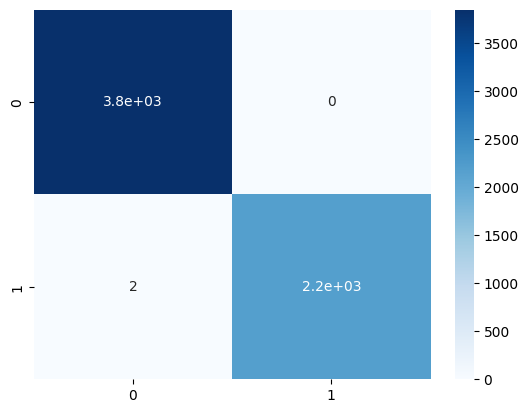

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test, pred_labels), annot=True, cmap='Blues')

## Section5. まとめ
SQLインジェクションの検出器を作成してみました。  
簡単な仮説検証や、簡易に特徴量の作成や追加についても触れてみました。特徴量エンジニアリングや扱うアルゴリズムによってモデルの精度や汎化性能が上がることをみていきました。特徴量を見つけ出すことは、現実での課題では非常に難しいことが多いですが、地道に特徴量を作り評価をするサイクルを繰り返すことで、より良いモデルを作成することが可能となります。